In [236]:
!pip install pyarrow
!pip install plotly
!pip install orion
!pip install tqdm
!pip install pandarallel
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 6.2 MB/s eta 0:00:0000:01


# Process operating data

In [189]:
import pandas as pd

operating_data_df =  pd.read_parquet('operating_data.parquet.gzip')
operating_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23236237 entries, 0 to 23236236
Data columns (total 6 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date          datetime64[ns]
 1   datatype      category      
 2   country       category      
 3   bidding_area  category      
 4   code          category      
 5   value         float32       
dtypes: category(4), datetime64[ns](1), float32(1)
memory usage: 354.6 MB


In [ ]:
import plotly.express as px
from plotly.subplots import make_subplots

swedish_wind = operating_data_df[(operating_data_df.country=='Sweden') & (operating_data_df.code=='WS')]
sweden_bedding_areas = swedish_wind.bidding_area.unique()
fig = make_subplots(rows=len(sweden_bedding_areas), cols=1,
                    subplot_titles=sweden_bedding_areas)
for i, area in enumerate(sweden_bedding_areas):
    df = swedish_wind[swedish_wind.bidding_area==area].sort_values(by=['date'])
    fig.add_trace(
        px.line(df, x='date', y='value').data[0],
        row=i+1, col=1
    )
fig.update_layout(height=900, width=1400, title_text="Wind gen in Sweden")
fig.show()

In [190]:
operating_data_wide = operating_data_df.pivot(index=['date','datatype', 'country', 'bidding_area'], columns='code', values='value')
operating_data_wide = operating_data_wide.reset_index()
operating_by_week = operating_data_wide.groupby(['country', 'bidding_area']).resample('W', on='date').mean(numeric_only=True).reset_index()
operating_by_week.country = operating_by_week.country.astype('object')
del operating_data_wide

In [155]:
def plot_operating_data_by_country(df, code, name, as_jpeg=False):
    mask1 = df[code].isnull()
    mask2 = df['bidding_area'].isin(['Sverige', 'Norge', 'Denmark', 'Finland', 'Estonia', 'Lativa', 'Lithuania'])
    data = df[~mask1 & mask2]
    # consumption = consumption.groupby(['country', 'bidding_area']).resample('W', on='date').mean(numeric_only=True).reset_index()
    # consumption.country = consumption.country.astype('object')
    fig = px.line(data, x='date', y=code, color='country', title=f'{name} by country')
    fig.update_traces(marker_size=2)
    fig.update_layout(legend= {'itemsizing': 'constant'})
    if as_jpeg:
        fig.show(renderer="jpeg", width=1400, height=500)
    else:
        fig.show()

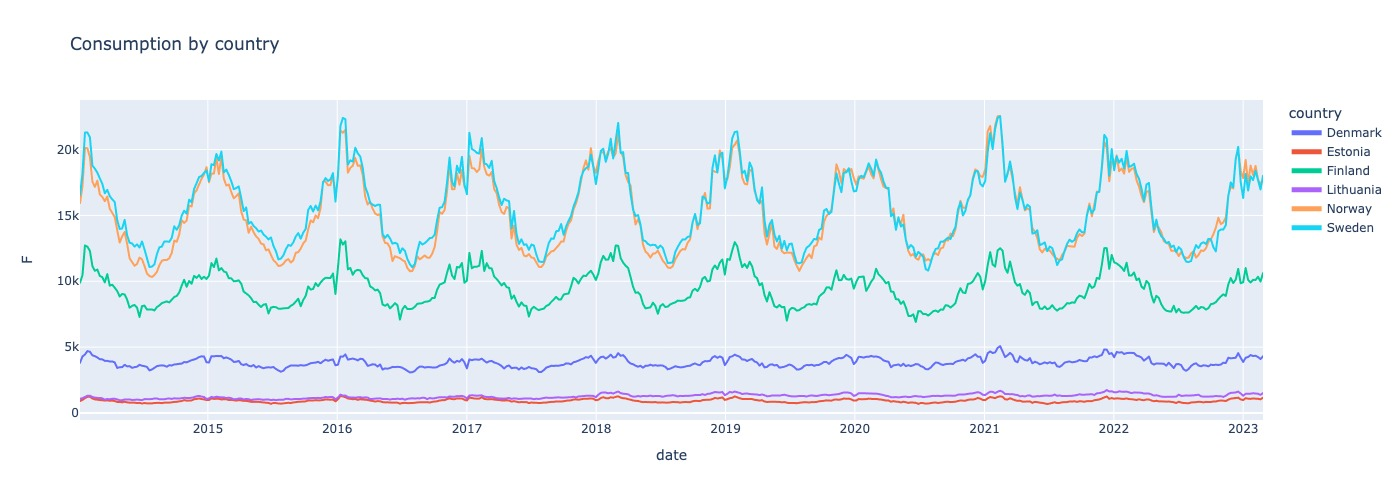

In [156]:
plot_operating_data_by_country(operating_by_week, 'F', 'Consumption', as_jpeg=True)

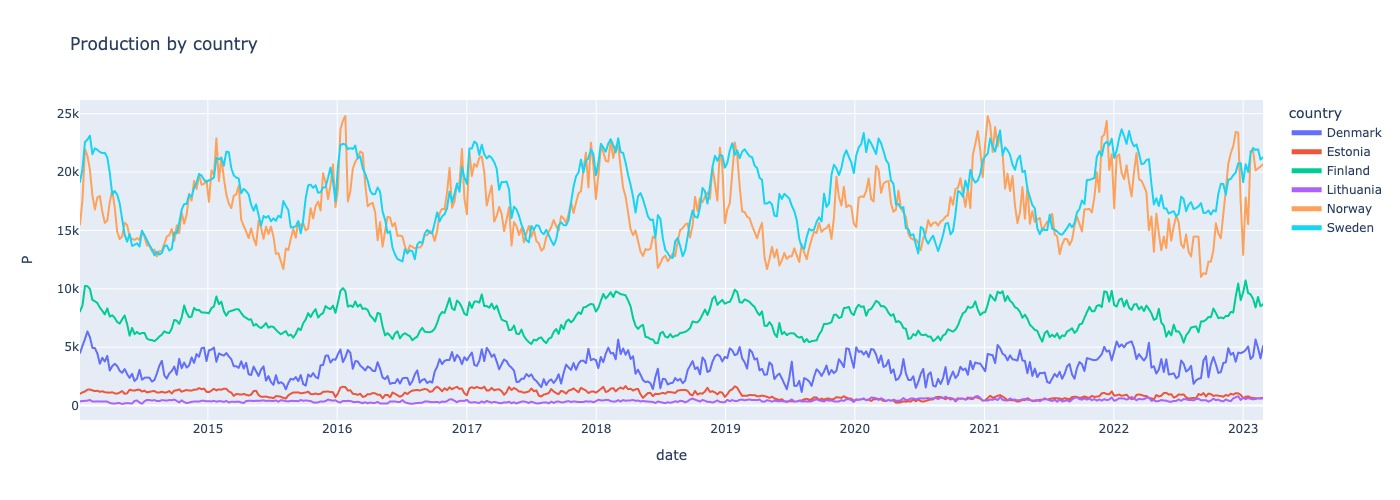

In [113]:
plot_operating_data_by_country(operating_by_week, 'P', 'Production', as_jpeg=True)

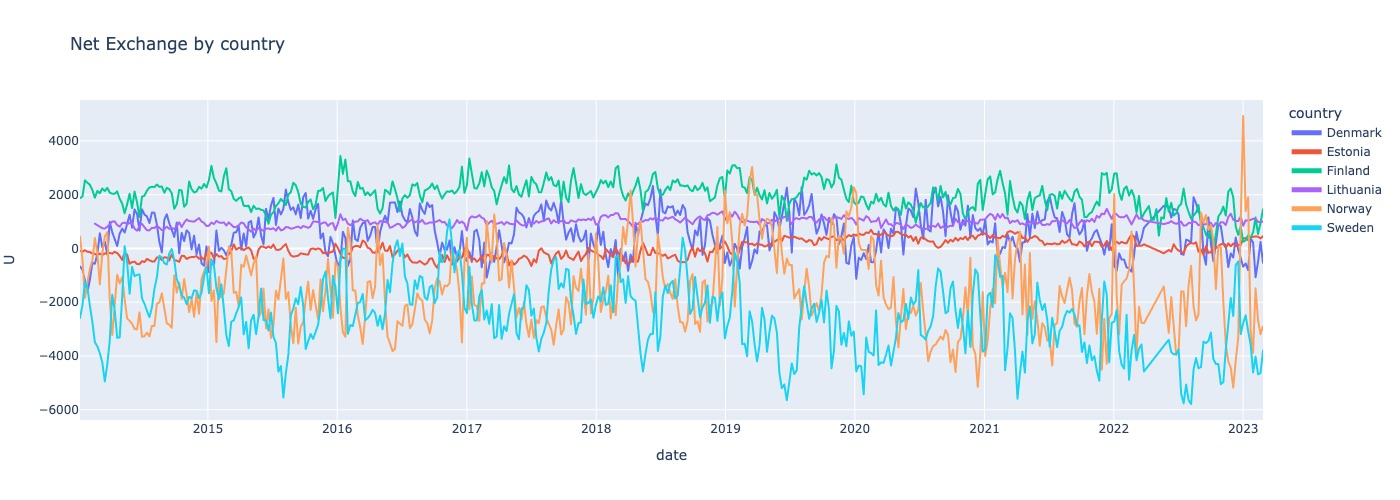

In [114]:
plot_operating_data_by_country(operating_by_week, 'U', 'Net Exchange', as_jpeg=True)

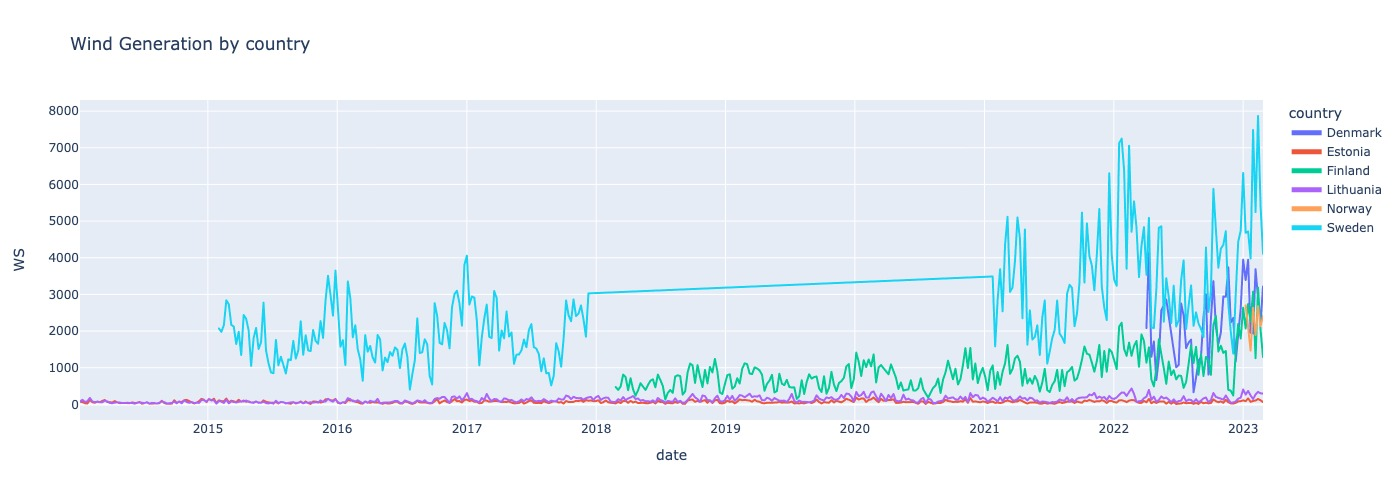

In [115]:
plot_operating_data_by_country(operating_by_week, 'WS', 'Wind Generation', as_jpeg=True)

# Process price data

In [187]:
prices_df = pd.read_parquet('spot_prices.parquet.gzip')
prices_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1298304 entries, 0 to 1467710
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   country        1298304 non-null  category      
 1   bidding_area   1298304 non-null  category      
 2   date           1298304 non-null  datetime64[ns]
 3   price_eur_mwh  1298304 non-null  float32       
dtypes: category(2), datetime64[ns](1), float32(1)
memory usage: 27.2 MB


In [188]:
prices_by_week = prices_df.groupby(['country', 'bidding_area']).resample('W', on='date').mean(numeric_only=True).reset_index()
prices_by_week.bidding_area = prices_by_week.bidding_area.astype('object')

In [247]:
prices_by_week = prices_by_week.sort_values(by=['date'])
fig = px.line(prices_by_week, x='date', y='price_eur_mwh', color='bidding_area', title=f'Spot Price by bidding area')
fig.update_layout(legend= {'itemsizing': 'constant'})
fig.update_traces(marker_size=2)
fig.show(width=1400, height=500)

In [124]:
pd.options.mode.chained_assignment = None  # default='warn'

def plot_prices_by_country(df, country, as_jpeg=False):
    prices = df[df.country == country]
    # prices.bidding_area = prices.bidding_area.astype('object')
    # prices = prices.groupby(['country', 'bidding_area']).resample('W', on='date').mean(numeric_only=True).reset_index()
    fig = px.line(prices, x='date', y='price_eur_mwh', color='bidding_area', title=f'Spot Price in {country}')
    fig.update_layout(legend= {'itemsizing': 'constant'})
    fig.update_traces(marker_size=2)
    if as_jpeg:
        fig.show(renderer="jpeg", width=1400, height=500)
    else:
        fig.show()

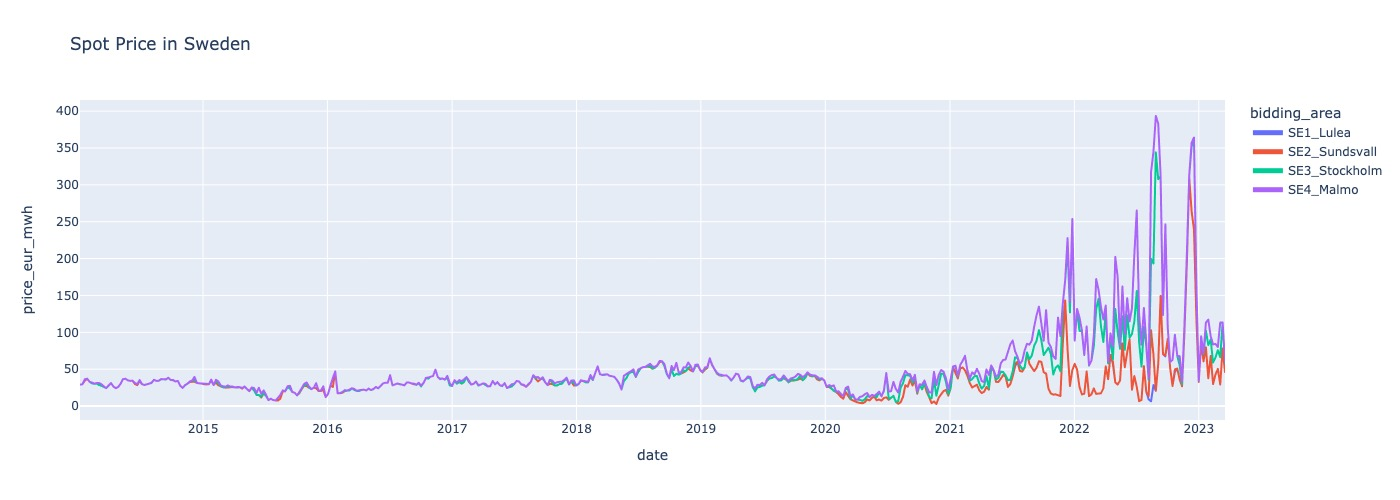

In [125]:
plot_prices_by_country(prices_by_week, 'Sweden', as_jpeg=True)

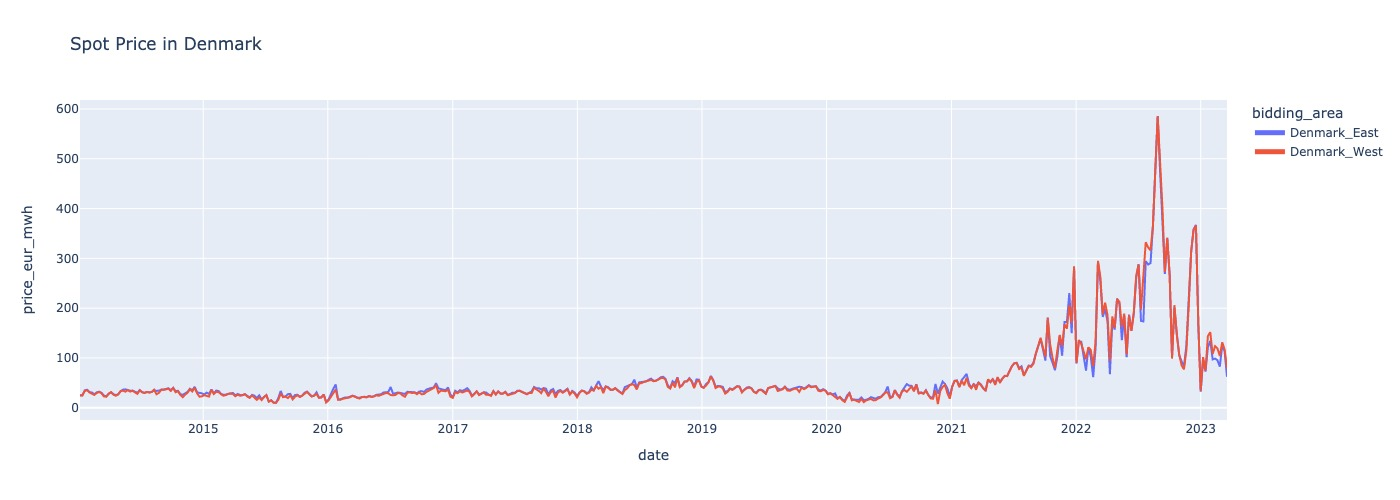

In [126]:
plot_prices_by_country(prices_by_week, 'Denmark', as_jpeg=True)

In [157]:
plot_prices_by_country(prices_by_week, 'Norway', as_jpeg=False)

# Correlation

In [254]:
operating_by_week.country = operating_by_week.country.astype('category')
operating_by_week.bidding_area = operating_by_week.bidding_area.astype('category')
prices_by_week.bidding_area = prices_by_week.bidding_area.astype('category')
prices_by_week.country = prices_by_week.country.astype('category')

In [212]:
area_mapping = {
    'Bergen': 'NO5 Norway',
    'Kristiansand': 'NO2 Norway',
    'Kristiansund': 'NO3 Norway',
    'Oslo': 'NO1 Norway',
    'Tromso': 'NO4 Norway',
    'Trondheim':  'NO3 Norway',
    'Denmark_East' : 'DK2 Denmark',
    'Denmark_West': 'DK1 Denmark',
    'Denmark West': 'DK1 Denmark',
    'Denmark East': 'DK2 Denmark',
    'DK1': 'DK1 Denmark',
    'DK2': 'DK2 Denmark',
    'SE1_Lulea': 'SE1 Sweden',
    'SE2_Sundsvall': 'SE2 Sweden',
    'SE3_Stockholm': 'SE3 Sweden',
    'SE4_Malmo': 'SE4 Sweden',
    'Sverige1': 'SE1 Sweden',
    'Sverige2': 'SE2 Sweden',
    'Sverige3': 'SE4 Sweden',
    'Sverige4': 'SE4 Sweden',
}

prices_by_week.bidding_area = prices_by_week.parallel_apply(lambda x: area_mapping[x.bidding_area] if x.bidding_area in area_mapping else x.bidding_area, axis=1)

In [213]:
operating_by_week.bidding_area = operating_by_week.parallel_apply(lambda x: area_mapping[x.bidding_area] if x.bidding_area in area_mapping else x.bidding_area, axis=1)

In [274]:
merged = operating_by_week.merge(prices_by_week, on=['date', 'country', 'bidding_area'], how='outer').sort_values(by=['date'])

In [280]:
merged = merged.rename(columns={
    "price_eur_mwh": "spot_price",
    "WS": "wind_settled",
    "WE": "wind_estimated",
    "F": "consumption_settled",
    "P": "production_settled",
    "U": "net_exchange",
    "E": "consumption_estimated",
    "PE": "production_estimated",
    "RN": "regulating_down",
    "RO": "regulating_up",
    "RC": "imbalance_consumption_price",
    "RP": "imbalance_production_purchase_price",
    "RS": "imbalance_production_sell_price",
    "DD": "dominating_regulation",})
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48567 entries, 4069 to 48566
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   country                              48567 non-null  object        
 1   bidding_area                         48567 non-null  object        
 2   date                                 48567 non-null  datetime64[ns]
 3   C                                    2046 non-null   float32       
 4   D                                    7858 non-null   float32       
 5   dominating_regulation                5775 non-null   float32       
 6   consumption_estimated                6236 non-null   float32       
 7   consumption_settled                  8653 non-null   float32       
 8   IP                                   877 non-null    float32       
 9   production_settled                   8653 non-null   float32       
 10  product

/var/folders/l_/yszbrvm96clcdwdldb5h3gmr0000gn/T/ipykernel_21963/1419923611.py:10: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

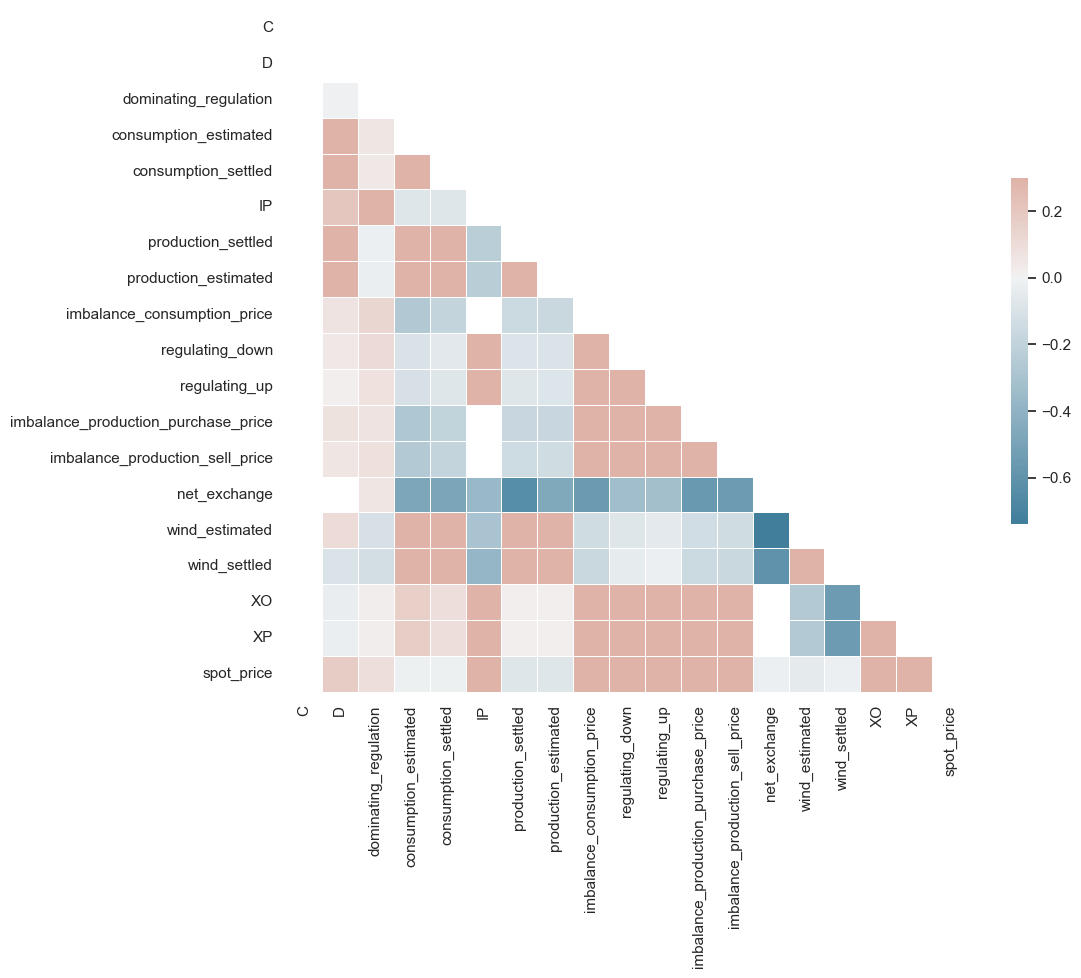

In [281]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Compute the correlation matrix
corr = merged.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# ML

In [ ]:
import plotly.express as px

bergen_df = prices_df[prices_df['bidding_area']=='Bergen'].sort_values(by=['date']).reset_index(drop=True)
fig = px.scatter(bergen_df, x='date', y='price_eur_mwh', color='country')
fig.show()

Estimated number of clusters: 1


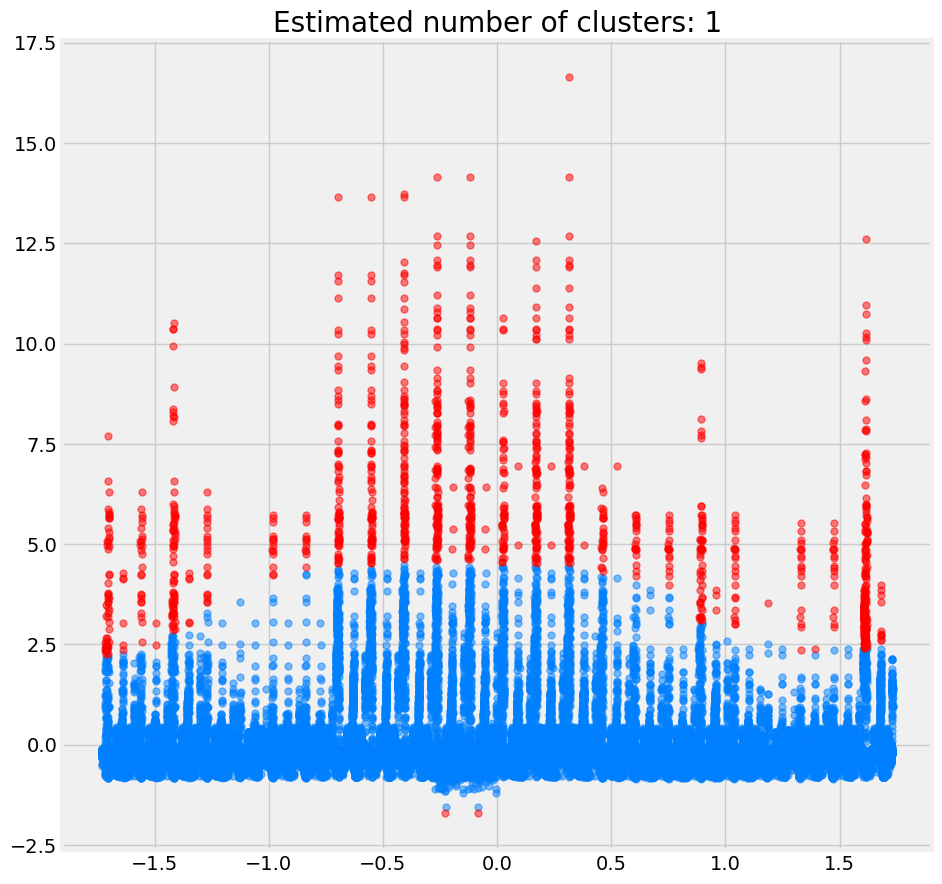

In [21]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
plt.style.use('fivethirtyeight')

X = [[i, prices_df['price_eur_mwh'][i]]  for i in range(len(bergen_df))]
X = StandardScaler().fit_transform(X)
db = DBSCAN(eps=0.5, min_samples=200).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

unique_labels = set(labels)
plt.figure(num=None, figsize=(10, 10), facecolor='w', edgecolor='k')
for k in unique_labels:
    col=[0,0.5,1,1]
    if k == -1:
        col = [1, 0, 0, 1]
    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', color=tuple(col),markersize=5, alpha=0.5)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', color=tuple(col), markersize=5, alpha=0.5)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Process weather data

In [46]:
import os
import pandas as pd

df = pd.read_csv('city_temperature.csv', sep=',', decimal='.')

/var/folders/l_/yszbrvm96clcdwdldb5h3gmr0000gn/T/ipykernel_16275/1989910942.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('city_temperature.csv', sep=',', decimal='.')


In [49]:
df[df['Country']=='Denmark']['City'].unique()


array(['Copenhagen'], dtype=object)